# Compile the main simulator code using cython 

In [1]:
!python setup.py build_ext --inplace

running build_ext
running build_ext


# Import all the relevant files 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import seaborn as sns

In [3]:
#Importing scripts:

#Import relevant frames:
import cbgt as cbgt
import pipeline_creation as pl_creat

#Import plotting functions:
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import postprocessing_helpers as post_help

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

2023-08-24 22:32:55,542	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 127.0.0.1:6379...
2023-08-24 22:32:55,549	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


<module 'postprocessing_helpers' from '/Users/cristina/Desktop/CBGTPy_release/CBGTPy/postprocessing_helpers.py'>

# Choose the experiment and create the main pipeline

In [4]:
#Choose the experiment
experiment_choice = 'stop-signal'
number_of_choices = 2

#Call choose_pipeline with the pipeline object
pl_creat.choose_pipeline(experiment_choice)

#Create the main pipeline
pl = pl_creat.create_main_pipeline(runloop=True)

#Define how many simulations to run 
#Each simulation is executed as a separate thread
num_sims = 1
num_cores = 7

#Set a seed
seed = np.random.randint(0,99999999,1)[0]
print(seed)

in choose pipeline
in reward pipeline
75434668


In [5]:
#Define the data and figure directory

data_dir = "./Data/"
figure_dir = "./Figures/"

# Running the pipeline

### Define configuration parameter

In [6]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 

configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None,
    'thalamic_threshold': 30.,
    'movement_time': ['mean', 250], #['constant', 300], #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout': 300, #default 1000
    
    'params': None, #neuron parameters (init_params.py)
    'pops': None,   #population parameters (init_params.py)
    'receps' : None, #receptor parameters (init_params.py)
    'base' : None, #baseline stimulation parameters (init_params.py)
    'dpmns' : None, #dopamine related parameters (init_params.py)
    'd1' : None, #D1-MSNs population related parameters (init_params.py)
    'd2' : None, #D2-MSNs population related parameters (init_params.py)
    'channels' : pd.DataFrame([['left'], ['right']], columns=['action']), #action channels related parameters (init_params.py)
    'number_of_choices':number_of_choices,
    'newpathways' : None, #connectivity parameters (popconstruct.py)
    'Q_support_params': None, #initialization of Q-values update (qvalues.py) 
    'Q_df_set': pd.DataFrame([[0.5, 0.5]],columns=["left", "right"]), #pd.DataFrame([[0.3,0.7]],columns=['left','right']), #initialized Q-values df (qvalues.py)  
    'n_trials': 2, #number of trials (generateepochs.py)
    'volatility': [None,"exact"], #frequency of changepoints (generateepochs.py)
    'conflict': (1.0, 0), #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.1, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 0.8, # amplitude of the cortical input over base line #0.85
    'sustainedfraction': 0.75,
    
    #Stop 1
    'stop_signal_present': [True,True],
    'stop_signal_probability': [1., 1.],  #[[1,3],[1,2]], #probability of trials that will get the stop signal / list of trial numbers
    'stop_signal_amplitude': [0.6, 0.6], # amplitude of the stop signal over base line
    'stop_signal_onset': [30.,60.], #in ms #antes 200
    'stop_signal_duration' : ["phase 0",145.], 
    'stop_signal_channel': ["all","all"], #"all" (all channels are given the stop signal) 
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signa
    'stop_signal_population':["STN","GPeA"],
    
    'record_variables':["stop_input"],
    
    
    #Opto
    'opt_signal_present': [False],
    'opt_signal_probability': [1.], #[0,1,2,3,4], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude': [.7], # ampitude of the stop signal over base line
    'opt_signal_onset': [30.], # in ms
    'opt_signal_duration': [150.],
    'opt_signal_channel': ["all"], # "all" (all channels are given the stop signal) 
    'opt_signal_population':["iSPN"],
}

### Run the simulation

In [7]:
results = cbgt.ExecutionManager(cores=7).run([pl]*num_sims,[configuration]*num_sims)  

SpawnThreadManagers <backend.Pipeline object at 0x7fb3691efd60>
(worker pid=2317) in choose pipeline
(worker pid=2317) conflict (1.0, 0)
(worker pid=2317) conflict (1.0, 0)
(worker pid=2317) sum 1.0
(worker pid=2317) n_prob_trials [2, 0]
(worker pid=2317) calc_rew        left  right
(worker pid=2317) 0  1.186756    0.0
(worker pid=2317) 1  0.902272    0.0
(worker pid=2317) reward_list        left  right
(worker pid=2317) 0  1.186756    0.0
(worker pid=2317) 1  0.902272    0.0
(worker pid=2317) in choose pipeline
(worker pid=2317) conflict (1.0, 0)
(worker pid=2317) conflict (1.0, 0)
(worker pid=2317) sum 1.0
(worker pid=2317) n_prob_trials [2, 0]
(worker pid=2317) calc_rew        left  right
(worker pid=2317) 0  1.186756    0.0
(worker pid=2317) 1  0.902272    0.0
(worker pid=2317) reward_list        left  right
(worker pid=2317) 0  1.186756    0.0
(worker pid=2317) 1  0.902272    0.0
SpawnThreadManagers <backend.Pipeline object at 0x7fb37cb31d00>
SpawnThreadManagers <backend.Pipeline 

(worker pid=2317) /Users/cristina/Desktop/CBGTPy_release/CBGTPy/qvalues.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=2317)   Q_df = Q_df.append(
(worker pid=2317) /Users/cristina/Desktop/CBGTPy_release/CBGTPy/qvalues.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=2317)   Q_df = Q_df.append(
(worker pid=2317) /Users/cristina/Desktop/CBGTPy_release/CBGTPy/qvalues.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=2317)   Q_df = Q_df.append(
(worker pid=2317) /Users/cristina/Desktop/CBGTPy_release/CBGTPy/qvalues.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
(worker pid=2317)   Q_df = Q

(worker pid=2317) agent.stop_popids [array([2, 3]), array([6, 7])]
(worker pid=2317) agent.stop_popids [array([2, 3]), array([6, 7])]
(worker pid=2317) stop stim started
(worker pid=2317) stop stim started
(worker pid=2317) gateFRs [15.55555556 16.88888889]
(worker pid=2317) thresholds_crossed []
(worker pid=2317) gateFRs [15.55555556 16.88888889]
(worker pid=2317) thresholds_crossed []
(worker pid=2317) trial_num 0
(worker pid=2317)   action
(worker pid=2317) 0   left
(worker pid=2317) 1  right
(worker pid=2317) chosen_action: stop
(worker pid=2317) trial_num 0
(worker pid=2317)   action
(worker pid=2317) 0   left
(worker pid=2317) 1  right
(worker pid=2317) chosen_action: stop
(worker pid=2317) stop stim started
(worker pid=2317) stop stim started
(worker pid=2317) gateFRs [27.55555556 13.55555556]
(worker pid=2317) thresholds_crossed []
(worker pid=2317) gateFRs [27.55555556 13.55555556]
(worker pid=2317) thresholds_crossed []
(worker pid=2317) trial_num 1
(worker pid=2317)   action

### Results

In [8]:
#List all the agent variables accessible
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_duration', 'stop_signal_channel', 'stop_signal_population', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'par', 'popconstruct', 'interface', 'gen_stop', 'gen_stop_2', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', '

In [9]:
results[0]['stop_list_trials_list']

[array([1, 0]), array([1, 0])]

In [ ]:
results[0]['meaneff_GABA']

In [ ]:
results[0]['stop_signal_amplitude']

In [ ]:
experiment_choice

In [10]:
#Extract all the relevant dataframes
firing_rates, rt_dist = plt_help.extract_relevant_frames(results,seed,experiment_choice)

/Users/cristina/Desktop/CBGTPy_release/CBGTPy/plotting_helper_functions.py:217: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rt_distribution = rt_distribution.append(rt)


In [11]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPeP_left,GPeP_right,GPeA_left,GPeA_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,78.000000,78.666667,24.044444,26.844444,56.279762,50.892857,5.526316,4.561404,2.000000,4.222222,3.111111,5.111111,0.000000,0.000000,4.666667,5.555556,7.333333,0.806452,0
1,76.888889,79.111111,23.933333,26.822222,56.815476,50.386905,5.438596,4.561404,2.222222,4.000000,3.333333,5.111111,0.000000,0.000000,4.666667,5.333333,7.333333,0.806452,1
2,76.666667,79.333333,24.133333,27.155556,56.636905,50.386905,5.526316,4.649123,2.000000,4.222222,3.111111,5.111111,0.000000,0.000000,4.666667,5.111111,7.333333,0.806452,2
3,75.777778,79.111111,24.222222,27.533333,56.607143,50.327381,5.526316,4.649123,1.777778,4.444444,3.333333,5.111111,0.000000,0.000000,4.666667,4.888889,7.555556,0.806452,3
4,75.777778,79.333333,24.488889,28.200000,56.755952,50.625000,5.350877,4.824561,1.777778,4.222222,3.333333,4.888889,0.000000,0.000000,4.666667,4.888889,7.555556,0.806452,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,72.666667,73.333333,24.422222,25.133333,52.113095,52.708333,8.070175,6.666667,4.000000,5.777778,5.333333,5.333333,2.777778,3.513072,9.111111,7.111111,8.000000,2.240143,2306
2307,73.555556,73.777778,24.422222,25.222222,51.815476,52.827381,8.157895,6.666667,4.000000,5.777778,5.333333,5.333333,2.777778,3.513072,8.888889,7.111111,8.000000,2.150538,2307
2308,73.777778,73.333333,24.622222,25.044444,51.458333,53.035714,8.070175,6.578947,3.777778,5.555556,5.333333,5.333333,2.696078,3.186275,8.888889,7.111111,7.777778,2.150538,2308
2309,73.555556,72.000000,24.955556,25.088889,51.279762,53.244048,7.982456,6.491228,4.000000,5.111111,5.333333,5.777778,2.614379,3.104575,8.888889,7.111111,7.777778,2.060932,2309


In [12]:
#Firing rates  
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed
0,0,GPi_left,78.000000,GPi,left,75434668_0
1,1,GPi_left,76.888889,GPi,left,75434668_0
2,2,GPi_left,76.666667,GPi,left,75434668_0
3,3,GPi_left,75.777778,GPi,left,75434668_0
4,4,GPi_left,75.777778,GPi,left,75434668_0
...,...,...,...,...,...,...
41593,2306,CxI_common,2.240143,CxI,common,75434668_0
41594,2307,CxI_common,2.150538,CxI,common,75434668_0
41595,2308,CxI_common,2.150538,CxI,common,75434668_0
41596,2309,CxI_common,2.060932,CxI,common,75434668_0


In [ ]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

In [ ]:
recorded_variables['stop_input']#.melt(id_vars='Time(ms)')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.5)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['stop_input'],hue='nuclei',lw=3.0,ax=ax)
# ax.set_ylabel("STN",fontweight='bold')
ax.legend_.remove()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.tight_layout()
fig.savefig(figure_dir+'stop_input.png')

In [14]:
#Extract the data tables from the agent
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,stop,0,301,301,555,555,left,0
1,stop,1156,1457,301,553,1709,left,0


In [ ]:
#Save the selected variables of results in the data_dir specified
cbgt.saveResults(results,data_dir+'network_data_'+str(seed)+'.pickle',['popfreqs','popdata','datatables'])

FileNotFoundError: [Errno 2] No such file or directory: './Figures/Example_FR_stopsignal.png'

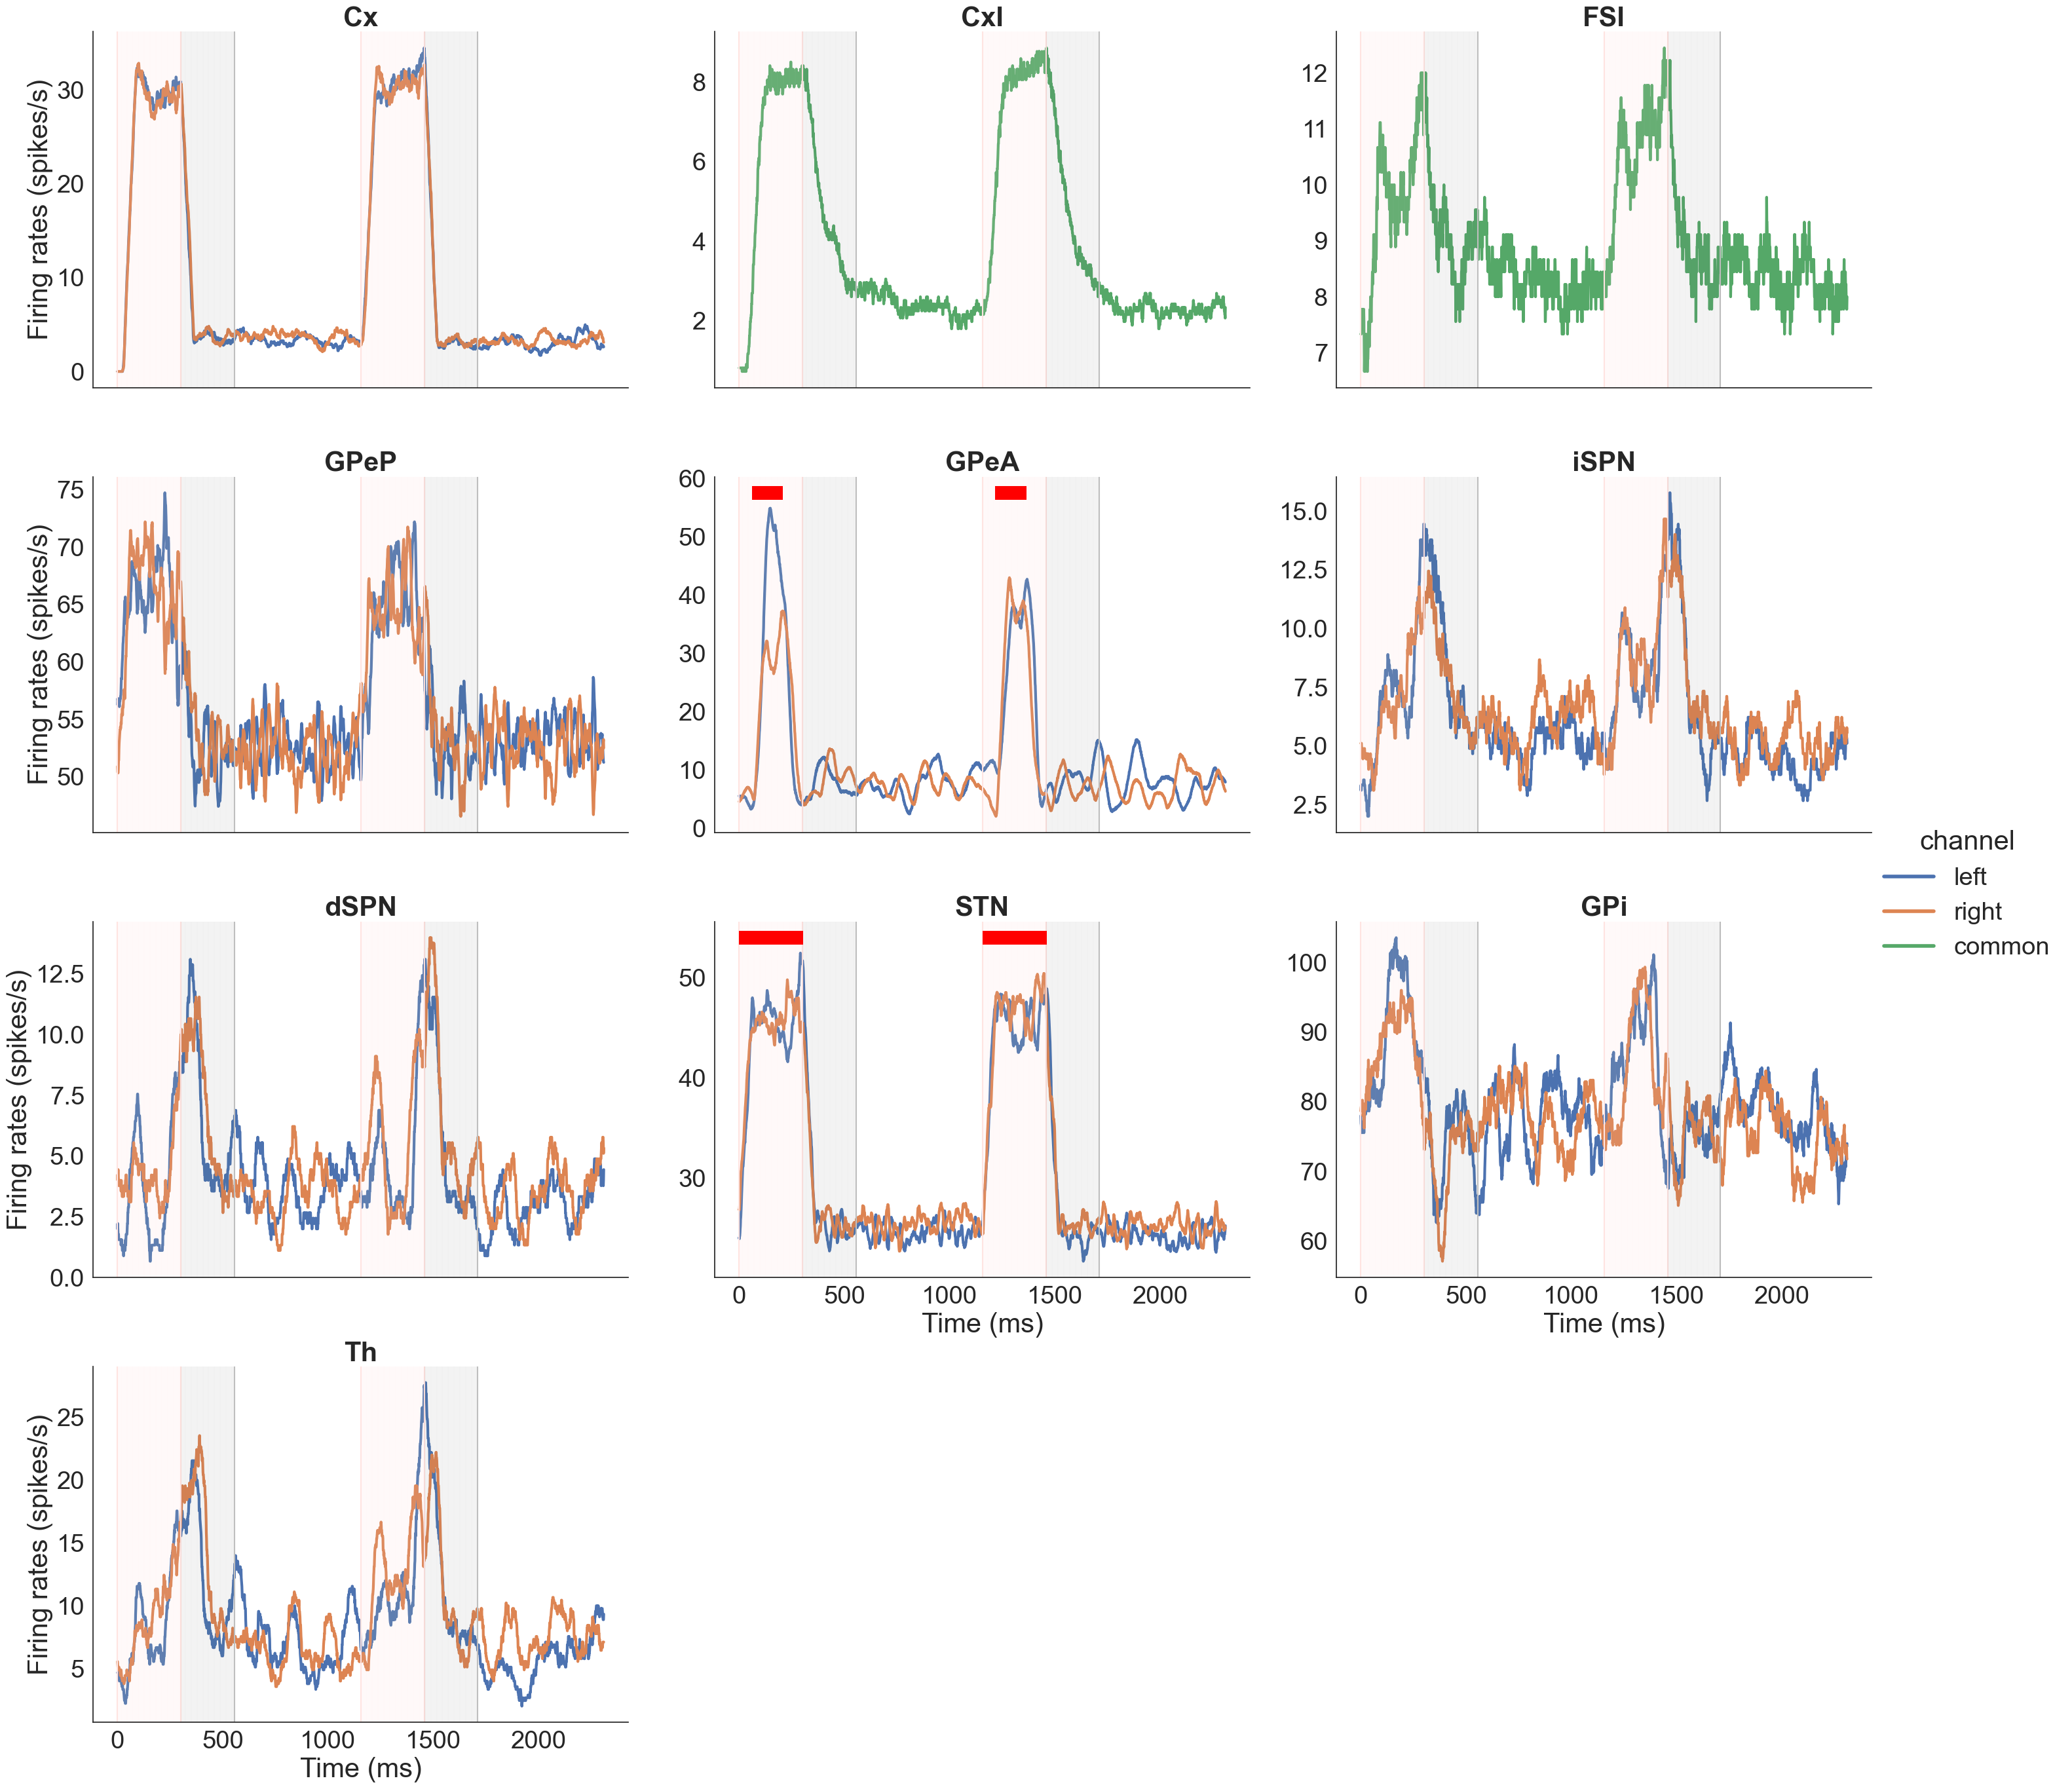

In [15]:
# Plot the firing rates extracted, figure handles are returned in fig_handles
FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_stopsignal.png",dpi=300)